# Test 2: Finetuned Models (DistilBERT & RoBERTa)

This notebook tests if finetuned transformer models have **bias towards resume writing style**:
- Do overstated resumes get higher seniority predictions?
- Do understated resumes get lower seniority predictions?
- Which words influence the model's decisions?

**Models tested:** DistilBERT, RoBERTa (run in parallel)

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\Rane\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Rane\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cuda


In [2]:
# Load test data
df = pd.read_csv("../Test 2 Data/test2_resumes.csv")
print(f"Loaded {len(df)} resume sets (each has neutral, overstated, understated versions)")
print(f"Seniority distribution: {df['seniority'].value_counts().to_dict()}")

Loaded 120 resume sets (each has neutral, overstated, understated versions)
Seniority distribution: {'junior': 40, 'mid': 40, 'senior': 40}


In [3]:
# Load both models
MODEL_PATHS = {
    'distilbert': '../Smaller Models/distilbert_resume_level',
    'roberta': '../Smaller Models/roberta_resume_level'
}

models = {}
tokenizers = {}

for name, path in MODEL_PATHS.items():
    print(f"Loading {name}...", end=" ")
    tokenizers[name] = AutoTokenizer.from_pretrained(path)
    models[name] = AutoModelForSequenceClassification.from_pretrained(path).to(device)
    models[name].eval()
    print("Done")

# Label mapping
id2label = {0: 'junior', 1: 'mid', 2: 'senior'}

Loading distilbert... Done
Loading roberta... Done


In [4]:
def predict(model_name, text):
    """Get prediction from a model."""
    tokenizer = tokenizers[model_name]
    model = models[model_name]
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        pred_id = torch.argmax(outputs.logits, dim=1).item()
    
    return id2label[pred_id]

## Run Predictions (Parallel)

Run both models on all resume versions in parallel.

In [5]:
# Run predictions for all resumes and all styles
results = []

styles = ['neutral', 'overstated', 'understated']
model_names = list(models.keys())

total = len(df) * len(styles) * len(model_names)
count = 0

for idx, row in df.iterrows():
    true_seniority = row['seniority']
    
    for style in styles:
        resume_text = str(row[style])
        
        for model_name in model_names:
            pred = predict(model_name, resume_text)
            
            results.append({
                'idx': idx,
                'true_seniority': true_seniority,
                'style': style,
                'model': model_name,
                'prediction': pred,
                'correct': pred == true_seniority,
                'resume_text': resume_text
            })
            
            count += 1
    
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{len(df)} resumes ({count}/{total} predictions)")

results_df = pd.DataFrame(results)
print(f"\nTotal predictions: {len(results_df)}")

Processed 20/120 resumes (120/720 predictions)
Processed 40/120 resumes (240/720 predictions)
Processed 60/120 resumes (360/720 predictions)
Processed 80/120 resumes (480/720 predictions)
Processed 100/120 resumes (600/720 predictions)
Processed 120/120 resumes (720/720 predictions)

Total predictions: 720


In [6]:
# Save results for later analysis
results_df.to_csv("finetuned_predictions.csv", index=False)
print("Saved to finetuned_predictions.csv")

Saved to finetuned_predictions.csv


---
## Analysis 1: Accuracy by Style

Does writing style affect prediction accuracy?

In [7]:
print("=" * 70)
print("ACCURACY BY STYLE AND MODEL")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 40)
    model_df = results_df[results_df['model'] == model_name]
    
    for style in ['neutral', 'overstated', 'understated']:
        style_df = model_df[model_df['style'] == style]
        acc = style_df['correct'].mean()
        print(f"  {style:<15}: {acc:.1%}")

ACCURACY BY STYLE AND MODEL

DISTILBERT
----------------------------------------
  neutral        : 42.5%
  overstated     : 33.3%
  understated    : 46.7%

ROBERTA
----------------------------------------
  neutral        : 35.0%
  overstated     : 33.3%
  understated    : 34.2%


---
## Analysis 2: Style Bias Detection

Key question: Do overstated resumes get predicted as higher seniority than they actually are?

In [8]:
# Map seniority to numeric for comparison
seniority_rank = {'junior': 0, 'mid': 1, 'senior': 2}
results_df['true_rank'] = results_df['true_seniority'].map(seniority_rank)
results_df['pred_rank'] = results_df['prediction'].map(seniority_rank)
results_df['rank_diff'] = results_df['pred_rank'] - results_df['true_rank']  # +ve = overestimate

print("=" * 70)
print("PREDICTION BIAS BY STYLE (rank_diff: +ve = overestimate, -ve = underestimate)")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = results_df[results_df['model'] == model_name]
    
    print(f"{'Style':<15} {'Avg Rank Diff':<18} {'Overestimates':<15} {'Underestimates'}")
    for style in ['overstated', 'neutral', 'understated']:
        style_df = model_df[model_df['style'] == style]
        avg_diff = style_df['rank_diff'].mean()
        over = (style_df['rank_diff'] > 0).sum()
        under = (style_df['rank_diff'] < 0).sum()
        print(f"{style:<15} {avg_diff:+.3f}{'':>12} {over:<15} {under}")

PREDICTION BIAS BY STYLE (rank_diff: +ve = overestimate, -ve = underestimate)

DISTILBERT
--------------------------------------------------
Style           Avg Rank Diff      Overestimates   Underestimates
overstated      -1.000             0               80
neutral         -0.800             1               68
understated     -0.708             2               62

ROBERTA
--------------------------------------------------
Style           Avg Rank Diff      Overestimates   Underestimates
overstated      +0.000             40              40
neutral         -0.017             38              40
understated     -0.008             39              40


In [9]:
print("=" * 70)
print("BIAS CHECK: Do overstated resumes get 'promoted'?")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = results_df[results_df['model'] == model_name]
    
    # Check: Junior resumes predicted as senior
    for true_level in ['junior', 'mid']:
        for style in ['overstated', 'neutral', 'understated']:
            subset = model_df[(model_df['true_seniority'] == true_level) & (model_df['style'] == style)]
            senior_preds = (subset['prediction'] == 'senior').sum()
            total = len(subset)
            pct = senior_preds / total * 100 if total > 0 else 0
            print(f"  {true_level.upper()} + {style:<12} → predicted SENIOR: {senior_preds}/{total} ({pct:.1f}%)")
        print()

BIAS CHECK: Do overstated resumes get 'promoted'?

DISTILBERT
--------------------------------------------------
  JUNIOR + overstated   → predicted SENIOR: 0/40 (0.0%)
  JUNIOR + neutral      → predicted SENIOR: 0/40 (0.0%)
  JUNIOR + understated  → predicted SENIOR: 0/40 (0.0%)

  MID + overstated   → predicted SENIOR: 0/40 (0.0%)
  MID + neutral      → predicted SENIOR: 1/40 (2.5%)
  MID + understated  → predicted SENIOR: 2/40 (5.0%)


ROBERTA
--------------------------------------------------
  JUNIOR + overstated   → predicted SENIOR: 0/40 (0.0%)
  JUNIOR + neutral      → predicted SENIOR: 0/40 (0.0%)
  JUNIOR + understated  → predicted SENIOR: 0/40 (0.0%)

  MID + overstated   → predicted SENIOR: 0/40 (0.0%)
  MID + neutral      → predicted SENIOR: 0/40 (0.0%)
  MID + understated  → predicted SENIOR: 0/40 (0.0%)



---
## Analysis 3: Same Person, Different Predictions?

For each person: do their 3 resume versions get different predictions?

In [10]:
print("=" * 70)
print("PREDICTION CONSISTENCY: Same person, different styles")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = results_df[results_df['model'] == model_name]
    
    inconsistent = 0
    style_changes = []
    
    for idx in df.index:
        person_preds = model_df[model_df['idx'] == idx].set_index('style')['prediction']
        
        if len(set(person_preds)) > 1:  # Different predictions for same person
            inconsistent += 1
            style_changes.append({
                'idx': idx,
                'true': df.loc[idx, 'seniority'],
                'neutral': person_preds.get('neutral', '?'),
                'overstated': person_preds.get('overstated', '?'),
                'understated': person_preds.get('understated', '?')
            })
    
    print(f"Resumes with INCONSISTENT predictions across styles: {inconsistent}/{len(df)} ({inconsistent/len(df)*100:.1f}%)")
    
    if style_changes:
        changes_df = pd.DataFrame(style_changes[:10])  # Show first 10
        print("\nSample inconsistent predictions:")
        print(changes_df.to_string(index=False))

PREDICTION CONSISTENCY: Same person, different styles

DISTILBERT
--------------------------------------------------
Resumes with INCONSISTENT predictions across styles: 27/120 (22.5%)

Sample inconsistent predictions:
 idx   true neutral overstated understated
  41    mid  junior     junior         mid
  48    mid  junior     junior      senior
  57    mid  junior     junior      senior
  61    mid  senior     junior      junior
  72    mid     mid     junior      junior
  80 senior  junior     junior      senior
  81 senior  junior     junior      senior
  82 senior  senior     junior      junior
  88 senior  junior     junior      senior
  90 senior  senior     junior      junior

ROBERTA
--------------------------------------------------
Resumes with INCONSISTENT predictions across styles: 2/120 (1.7%)

Sample inconsistent predictions:
 idx   true neutral overstated understated
   6 junior  junior        mid         mid
   8 junior  junior        mid      junior


---
## Analysis 4: Word Influence Analysis

Which words appear more in resumes that got predicted as Senior vs Junior?

In [11]:
# Power words and humble words from our validation metric
POWER_WORDS = {
    'spearheaded', 'revolutionized', 'pioneered', 'orchestrated', 'architected',
    'transformed', 'drove', 'championed', 'accelerated', 'maximized',
    'optimized', 'elevated', 'propelled', 'commanded', 'masterminded',
    'dramatically', 'significantly', 'substantially', 'exponentially', 'exceptionally',
    'outstanding', 'exceptional', 'remarkable', 'extraordinary', 'tremendous',
    'critical', 'crucial', 'vital', 'strategic', 'innovative',
    'enterprise', 'comprehensive', 'extensive', 'robust', 'cutting-edge',
    'visionary', 'influential', 'instrumental', 'pivotal', 'key'
}

HUMBLE_WORDS = {
    'helped', 'assisted', 'supported', 'contributed', 'participated',
    'aided', 'collaborated', 'worked', 'involved', 'engaged',
    'some', 'basic', 'minor', 'small', 'routine', 'standard', 'general',
    'occasional', 'limited', 'partial', 'modest', 'simple',
    'team', 'alongside', 'together', 'group', 'collective',
    'somewhat', 'relatively', 'fairly', 'adequately', 'sufficiently'
}

def count_words(text, word_set):
    words = re.findall(r'\b[a-z]+\b', str(text).lower())
    return sum(1 for w in words if w in word_set)

In [12]:
print("=" * 70)
print("WORD INFLUENCE: Power/Humble words in predictions")
print("=" * 70)

results_df['power_count'] = results_df['resume_text'].apply(lambda x: count_words(x, POWER_WORDS))
results_df['humble_count'] = results_df['resume_text'].apply(lambda x: count_words(x, HUMBLE_WORDS))

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = results_df[results_df['model'] == model_name]
    
    print(f"{'Prediction':<12} {'Avg Power Words':<18} {'Avg Humble Words'}")
    for pred in ['senior', 'mid', 'junior']:
        pred_df = model_df[model_df['prediction'] == pred]
        avg_power = pred_df['power_count'].mean()
        avg_humble = pred_df['humble_count'].mean()
        print(f"{pred:<12} {avg_power:.1f}{'':>14} {avg_humble:.1f}")

WORD INFLUENCE: Power/Humble words in predictions

DISTILBERT
--------------------------------------------------
Prediction   Avg Power Words    Avg Humble Words
senior       1.9               11.8
mid          2.3               9.7
junior       9.4               7.6

ROBERTA
--------------------------------------------------
Prediction   Avg Power Words    Avg Humble Words
senior       nan               nan
mid          8.8               7.9
junior       0.7               7.3


In [13]:
# Detailed word analysis: which specific words appear in senior predictions
def get_word_freq(texts, word_set):
    counts = Counter()
    for text in texts:
        words = re.findall(r'\b[a-z]+\b', str(text).lower())
        for w in words:
            if w in word_set:
                counts[w] += 1
    return counts

print("=" * 70)
print("TOP POWER WORDS IN SENIOR PREDICTIONS vs JUNIOR PREDICTIONS")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    model_df = results_df[results_df['model'] == model_name]
    
    senior_texts = model_df[model_df['prediction'] == 'senior']['resume_text']
    junior_texts = model_df[model_df['prediction'] == 'junior']['resume_text']
    
    senior_words = get_word_freq(senior_texts, POWER_WORDS)
    junior_words = get_word_freq(junior_texts, POWER_WORDS)
    
    print("Power words in SENIOR predictions:", dict(senior_words.most_common(5)))
    print("Power words in JUNIOR predictions:", dict(junior_words.most_common(5)))

TOP POWER WORDS IN SENIOR PREDICTIONS vs JUNIOR PREDICTIONS

DISTILBERT
------------------------------------------------------------
Power words in SENIOR predictions: {'strategic': 12, 'key': 11, 'comprehensive': 7, 'spearheaded': 5, 'robust': 5}
Power words in JUNIOR predictions: {'strategic': 389, 'comprehensive': 317, 'key': 304, 'critical': 262, 'robust': 146}

ROBERTA
------------------------------------------------------------
Power words in SENIOR predictions: {}
Power words in JUNIOR predictions: {'key': 2}


---
## Analysis 5: Misclassification Deep Dive

When a junior is predicted as senior (or vice versa), what words were present?

In [14]:
print("=" * 70)
print("MISCLASSIFICATION ANALYSIS")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    model_df = results_df[results_df['model'] == model_name]
    
    # Juniors predicted as Senior (overpromoted)
    overpromoted = model_df[(model_df['true_seniority'] == 'junior') & (model_df['prediction'] == 'senior')]
    print(f"\nJuniors predicted as SENIOR: {len(overpromoted)}")
    if len(overpromoted) > 0:
        print(f"  Style breakdown: {overpromoted['style'].value_counts().to_dict()}")
        print(f"  Avg power words: {overpromoted['power_count'].mean():.1f}")
        print(f"  Avg humble words: {overpromoted['humble_count'].mean():.1f}")
    
    # Seniors predicted as Junior (underpromoted)
    underpromoted = model_df[(model_df['true_seniority'] == 'senior') & (model_df['prediction'] == 'junior')]
    print(f"\nSeniors predicted as JUNIOR: {len(underpromoted)}")
    if len(underpromoted) > 0:
        print(f"  Style breakdown: {underpromoted['style'].value_counts().to_dict()}")
        print(f"  Avg power words: {underpromoted['power_count'].mean():.1f}")
        print(f"  Avg humble words: {underpromoted['humble_count'].mean():.1f}")

MISCLASSIFICATION ANALYSIS

DISTILBERT
------------------------------------------------------------

Juniors predicted as SENIOR: 0

Seniors predicted as JUNIOR: 94
  Style breakdown: {'overstated': 40, 'neutral': 29, 'understated': 25}
  Avg power words: 12.0
  Avg humble words: 7.1

ROBERTA
------------------------------------------------------------

Juniors predicted as SENIOR: 0

Seniors predicted as JUNIOR: 0


---
## Summary Visualization

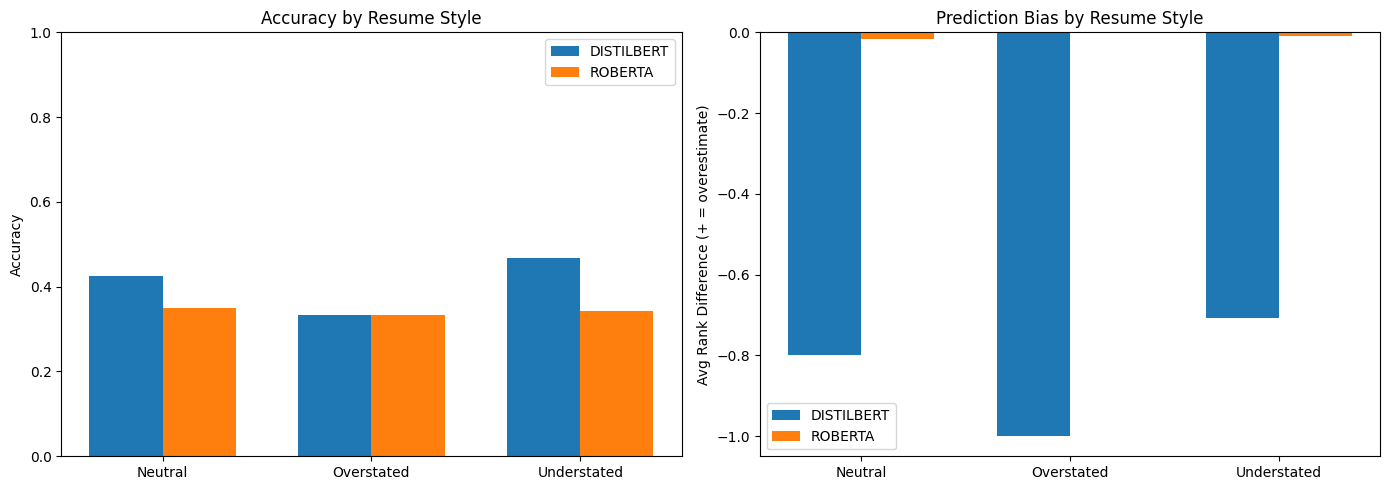

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by style for each model
styles = ['neutral', 'overstated', 'understated']
x = np.arange(len(styles))
width = 0.35

for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    accs = [model_df[model_df['style'] == s]['correct'].mean() for s in styles]
    axes[0].bar(x + i*width, accs, width, label=model_name.upper())

axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy by Resume Style')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(['Neutral', 'Overstated', 'Understated'])
axes[0].legend()
axes[0].set_ylim(0, 1)

# Plot 2: Average rank difference (bias) by style
for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    diffs = [model_df[model_df['style'] == s]['rank_diff'].mean() for s in styles]
    axes[1].bar(x + i*width, diffs, width, label=model_name.upper())

axes[1].set_ylabel('Avg Rank Difference (+ = overestimate)')
axes[1].set_title('Prediction Bias by Resume Style')
axes[1].set_xticks(x + width/2)
axes[1].set_xticklabels(['Neutral', 'Overstated', 'Understated'])
axes[1].legend()
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

---
## Findings Summary

This section will be filled after running the tests with the actual results.

In [16]:
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

for model_name in model_names:
    model_df = results_df[results_df['model'] == model_name]
    
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    
    # Overall accuracy
    neutral_acc = model_df[model_df['style'] == 'neutral']['correct'].mean()
    over_acc = model_df[model_df['style'] == 'overstated']['correct'].mean()
    under_acc = model_df[model_df['style'] == 'understated']['correct'].mean()
    
    print(f"Neutral accuracy:     {neutral_acc:.1%}")
    print(f"Overstated accuracy:  {over_acc:.1%}")
    print(f"Understated accuracy: {under_acc:.1%}")
    
    # Bias
    over_bias = model_df[model_df['style'] == 'overstated']['rank_diff'].mean()
    under_bias = model_df[model_df['style'] == 'understated']['rank_diff'].mean()
    
    print(f"\nOverstated bias:  {over_bias:+.3f} ({'tends to overestimate' if over_bias > 0 else 'tends to underestimate'})")
    print(f"Understated bias: {under_bias:+.3f} ({'tends to overestimate' if under_bias > 0 else 'tends to underestimate'})")
    
    # Inconsistency
    inconsistent = 0
    for idx in df.index:
        preds = model_df[model_df['idx'] == idx]['prediction'].unique()
        if len(preds) > 1:
            inconsistent += 1
    print(f"\nInconsistent predictions: {inconsistent}/{len(df)} ({inconsistent/len(df)*100:.1f}%)")

FINAL SUMMARY

DISTILBERT
--------------------------------------------------
Neutral accuracy:     42.5%
Overstated accuracy:  33.3%
Understated accuracy: 46.7%

Overstated bias:  -1.000 (tends to underestimate)
Understated bias: -0.708 (tends to underestimate)

Inconsistent predictions: 27/120 (22.5%)

ROBERTA
--------------------------------------------------
Neutral accuracy:     35.0%
Overstated accuracy:  33.3%
Understated accuracy: 34.2%

Overstated bias:  +0.000 (tends to underestimate)
Understated bias: -0.008 (tends to underestimate)

Inconsistent predictions: 2/120 (1.7%)
